# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [30]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import shutil
import os
import cv2
import sklearn 
from PIL import Image
import glob
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
# from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


Load the dataset.

In [1]:
# Load and unzip the dataset
import zipfile

zip_file_name = 'Data.zip' 

try:
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall() # Extracts all contents to the current directory
    print(f"Successfully unzipped '{zip_file_name}' to the current directory.")
except zipfile.BadZipFile:
    print(f"Error: '{zip_file_name}' is not a valid ZIP file.")
except FileNotFoundError:
    print(f"Error: '{zip_file_name}' not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Successfully unzipped 'Data.zip' to the current directory.


### **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [2]:
# Create a function to load the raw images

def load_images_from_glob(directory_path):
    
    loaded_images = [] 
    loaded_lables = []
    pattern = directory_path
    image_paths = glob.glob(os.path.join(pattern,'*.png'))
    for img_path in image_paths:
        
        try:
            img = Image.open(img_path)
            loaded_images.append(img)
        except IOError:
            print(f"Could not load image: {img_path}")
    return loaded_images

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [3]:
# Get the images and their labels
image_data = []
image_labels = []
curr_path ="data"
classes = 7 #data belonges to 7 class
for i in os.listdir(curr_path):
    dir = curr_path + '/' + i
    for j in os.listdir(dir):
        img_path = dir + '/' + j
        img = cv2.imread(img_path,-1)
        image_data.append(img)
        image_labels.append(i)

image_data = np.array(image_data)
image_labels = np.array(image_labels)
print(image_data.shape, image_labels.shape)


(7625, 256, 256, 3) (7625,)


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

Text(0, 0.5, 'Number of images')

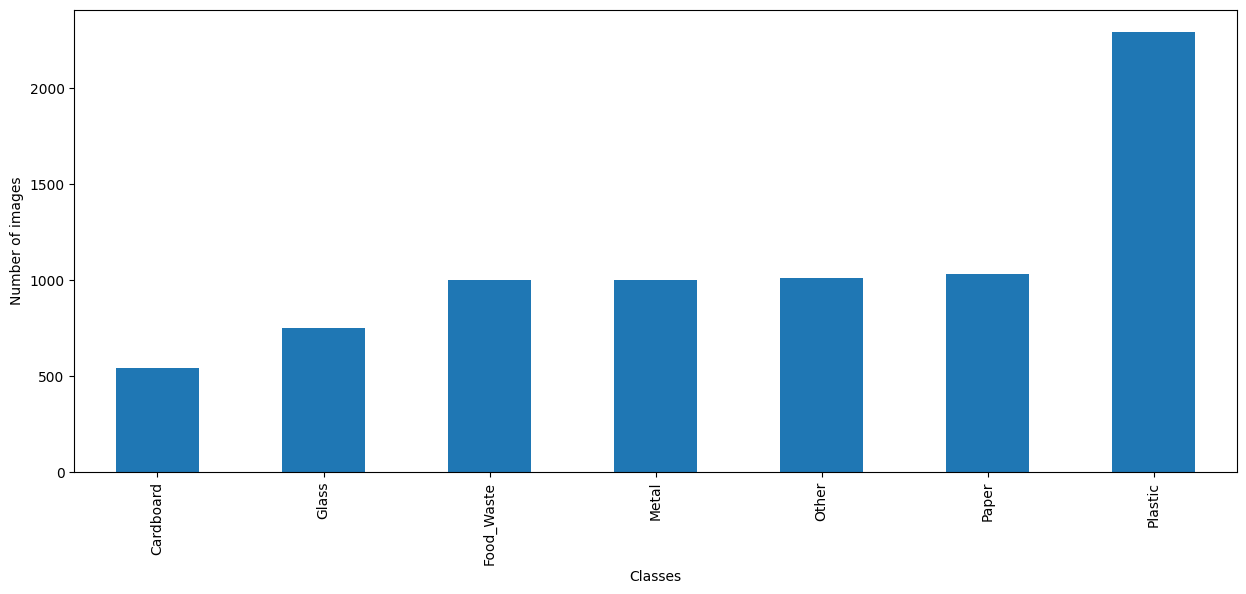

In [4]:
# Visualise Data Distribution
data_dic = {}
curr_path = "data"
for folder in os.listdir(curr_path):
    data_dic[folder] = len(os.listdir(curr_path + '/' + folder))
    #print(len(os.listdir(curr_path + '/' + folder)))
    data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Classes')
plt.ylabel('Number of images')


#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

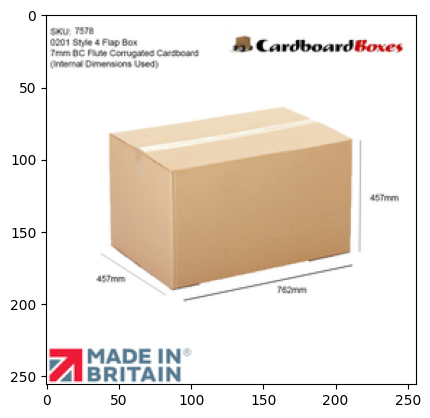

In [10]:
# Visualise Sample Images (across different labels)

images = load_images_from_glob(os.path.join("data","Cardboard"))
plt.imshow(images[10])

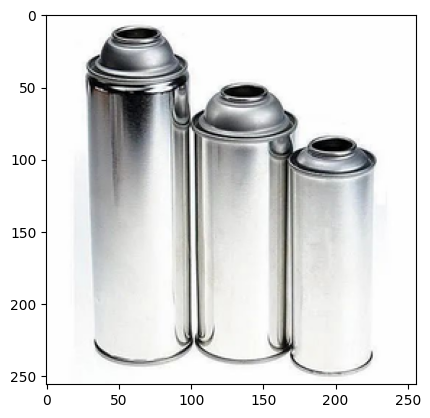

In [11]:
images = load_images_from_glob(os.path.join("data","Metal"))
plt.imshow(images[10])

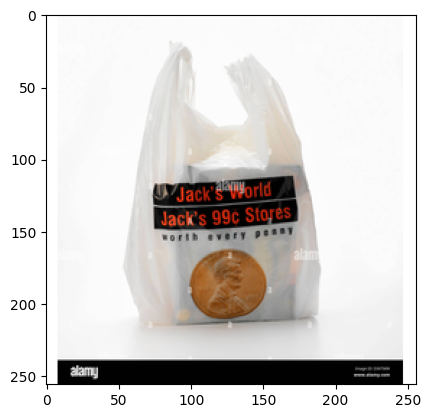

In [12]:
images = load_images_from_glob(os.path.join("data","Plastic"))
plt.imshow(images[10])

'Glass'

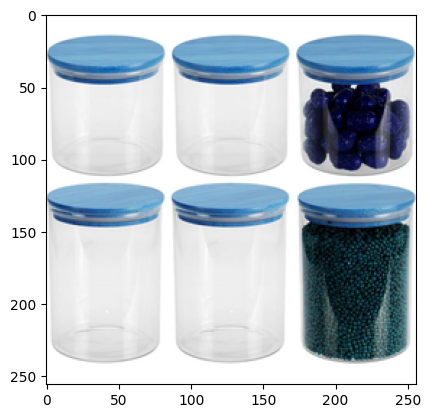

In [5]:
plt.imshow(image_data[2000])
image_labels[2000]

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [13]:
# Find the smallest and largest image dimensions from the data set
a,rows,columns,d = image_data.shape
largest_dim = max(rows, columns)
smallest_dim = min(rows, columns)
print("Largest Dimensions",largest_dim)
print("smallest Dimensions",smallest_dim)



Largest Dimensions 256
smallest Dimensions 256


In [14]:
# Resize the image dimensions
image_data = []
image_labels = []
curr_path ="data"
classes = 7 #data belonges to 7 class
for i in os.listdir(curr_path):
    dir = curr_path + '/' + i
    for j in os.listdir(dir):
        img_path = dir + '/' + j
        img = cv2.imread(img_path,-1)
        img = cv2.resize(img,(224,224),interpolation = cv2.INTER_NEAREST)
        image_data.append(img)
        image_labels.append(i)

image_data = np.array(image_data)
image_labels = np.array(image_labels)
print(image_data.shape, image_labels.shape)


(7625, 224, 224, 3) (7625,)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [ ]:
# Encode the labels suitably



### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [15]:
# Assign specified parts of the dataset to train and validation sets

# Where all dataset is there
data_dir = 'data'

# Training data dir
training_dir = 'Train'

# Test data dir
testing_dir = 'Test'

# Ratio of training and testing data
train_test_ratio = 0.8 


def split_dataset_into_test_and_train_sets(all_data_dir = data_dir, training_data_dir = training_dir, testing_data_dir=testing_dir, train_test_ratio = 0.8):
    # Recreate testing and training directories
    
    if not os.path.exists(training_data_dir):
            os.mkdir(training_data_dir)

    if not os.path.exists(testing_data_dir):
            os.mkdir(testing_data_dir)               
    
    num_training_files = 0
    num_testing_files = 0


    for subdir, dirs, files in os.walk(all_data_dir):
        
        category_name = os.path.basename(subdir)
        
        # print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
              continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name
        
        # creating subdir for each sub category
        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)   

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)
            
        file_list = glob.glob(os.path.join(subdir,'*.png'))

        #print(os.path.join(all_data_dir, subdir))
        print(str(category_name) + ' has ' + str(len(files)) + ' images') 
        random_set = np.random.permutation((file_list))
        # copy percentage of data from each category to train and test directory
        train_list = random_set[:round(len(random_set)*(train_test_ratio))] 
        test_list = random_set[-round(len(random_set)*(1-train_test_ratio)):]

  

        for lists in train_list : 
            shutil.copy(lists, training_data_dir + '/' + category_name + '/' )
            num_training_files += 1
  
        for lists in test_list : 
            shutil.copy(lists, testing_data_dir + '/' + category_name + '/' )
            num_testing_files += 1
  

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")


In [18]:
split_dataset_into_test_and_train_sets()

Cardboard has 540 images
Food_Waste has 1000 images
Glass has 750 images
Metal has 1000 images
Other has 1010 images
Paper has 1030 images
Plastic has 2295 images
Processed 6100 training files.
Processed 1525 testing files.


In [27]:
image_size = 224
batch_size = 64

train_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_generator = train_data_gen.flow_from_directory(training_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical')
valid_generator = valid_data_gen.flow_from_directory(testing_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical')

Found 6100 images belonging to 7 classes.
Found 1525 images belonging to 7 classes.


### **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

#### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [36]:
# Build and compile the model
# model
model = Sequential()
input_shape = (224, 224, 3)
num_classes = 7

# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape)) # input shape = (img_rows, img_cols, 1)

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third conv layer
model.add(Conv2D(64, kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 220, 220, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 108, 108, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,945,223 (91.34 MB)

 Trainable params: 23,945,223 (91.34 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [38]:
# Training
# fit the model
epochs = 5
model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n//batch_size,
    epochs=epochs,
    verbose=1)


Epoch 1/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 497s 5s/step - accuracy: 0.1643 - loss: 31.9910 - val_accuracy: 0.2160 - val_loss: 2.0666
Epoch 2/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 23s 194ms/step - accuracy: 0.2656 - loss: 4.5090 - val_accuracy: 0.2099 - val_loss: 2.0596
Epoch 3/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 524s 6s/step - accuracy: 0.2021 - loss: 3.2914 - val_accuracy: 0.2948 - val_loss: 1.9516
Epoch 4/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 29s 260ms/step - accuracy: 0.3906 - loss: 2.0815 - val_accuracy: 0.2887 - val_loss: 1.9519
Epoch 5/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 532s 6s/step - accuracy: 0.2735 - loss: 2.1729 - val_accuracy: 0.2948 - val_loss: 1.9487


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [41]:
# Evaluate on the test set; display suitable metrics

# Score
score = model.evaluate(valid_generator, verbose=0)
print('Test Loss', score[0])
print('Test accuracy', score[1])


Test Loss 1.9486005306243896
Test accuracy 0.2963934540748596


In [43]:
y_pred = model.predict(valid_generator)

24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 756ms/step


In [44]:
y_pred

array([[0.1428269 , 0.14286235, 0.14283785, ..., 0.14285651, 0.14285667,
        0.14290424],
       [0.1428269 , 0.14286235, 0.14283785, ..., 0.14285651, 0.14285667,
        0.14290424],
       [0.1428269 , 0.14286235, 0.14283785, ..., 0.14285651, 0.14285667,
        0.14290424],
       ...,
       [0.1428269 , 0.14286235, 0.14283785, ..., 0.14285651, 0.14285667,
        0.14290424],
       [0.1428269 , 0.14286235, 0.14283785, ..., 0.14285651, 0.14285667,
        0.14290424],
       [0.1428269 , 0.14286235, 0.14283785, ..., 0.14285651, 0.14285667,
        0.14290424]], dtype=float32)

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* 1.	The data has 7,625 Images.
        a.	Glass has 750 images
        b.	Metal has 1000 images
        c.	Other has 1010 images
        d.	Paper has 1030 images
        e.	Plastic has 2295 images
        f.	Cardboard has 540 images
        g.	Food_Waste has 1000 images
2.	Plastic is the highest number of images then followed by paper.
3.	Cardboards is the lowest number.
4.	The dimensions of the images are mostly same.
5.	After splitting the data into test and train ;  train data set got 6100 and test data got 1525 images
6.	After model is built we got 23,945,223 total parameters.
7.	When executed the model, loss  gradually reduced and accuracy improved ( Transfer learning may be improved the accuracy more)

* Report model training results
* accuracy: 0.2735 - loss: 2.1729 - val_accuracy: 0.2948 - val_loss: 1.9487
Test Loss 1.9486005306243896
Test accuracy 0.2963934540748596
